In [1]:
!pip install tensorflow pandas numpy


Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6118.7622 - mae: 46.1209 - val_loss: 1493.6067 - val_mae: 22.4509
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 843.0093 - mae: 17.0903 - val_loss: 417.7648 - val_mae: 13.4610
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 298.0465 - mae: 11.2210 - val_loss: 99.5270 - val_mae: 7.1753
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 78.5246 - mae: 6.0760 - val_loss: 45.1852 - val_mae: 4.5596
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36.2569 - mae: 3.6873 - val_loss: 31.8755 - val_mae: 3.4777
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.1781 - mae: 3.3070 - val_loss: 25.1700 - val_mae: 2.7713
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6745 - mae: 2.6190 - val_loss: 18.2277 - val_mae: 2.3753
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.1859 - mae: 2.0707 - val_loss: 12.8320 - val_mae: 2.2250
Epoch 9/100
136/136

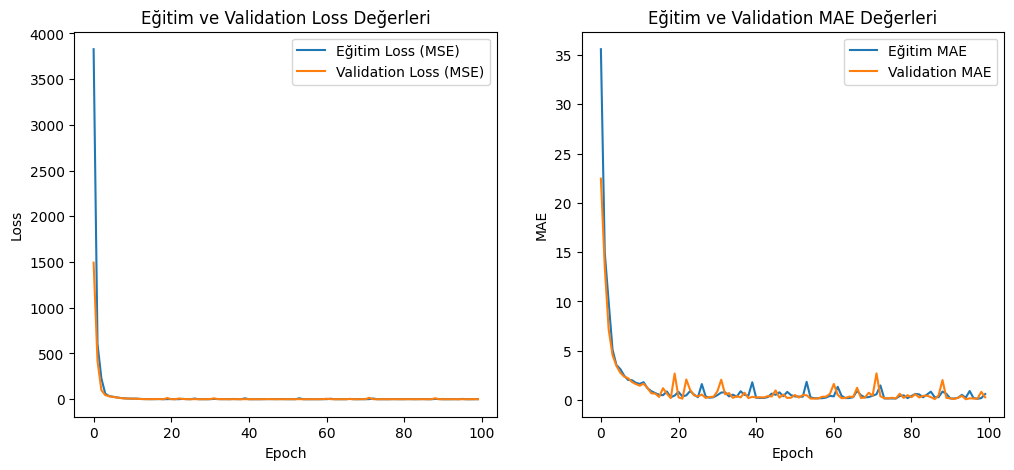

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2085 - mae: 0.2825
Test Loss (Besin Tahmini): 0.20870152115821838
Test MAE (Besin Tahmini): 0.2806724011898041
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model Accuracy (R^2 Score): 0.9939522555179545


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 📌 Kullanıcı veri setini yükle
user_df = pd.read_csv("Final_Updated_User_Dataset.csv")
food_df = pd.read_csv("Food_Dataset.csv")

# 📌 Kullanıcı veri setindeki sütunları temizle
user_df.columns = user_df.columns.str.lower().str.replace(" ", "_")
food_df.columns = food_df.columns.str.lower().str.replace(" ", "_")

# 📌 Hipertansiyon ve diyabet sütunlarını 0/1 formatına çevir
user_df["bpq020"] = user_df["bpq020"].apply(lambda x: 1 if x == 1 else 0)
user_df["diq010"] = user_df["diq010"].apply(lambda x: 1 if x == 1 else 0)

# 📌 Hedef değişkenleri belirle
nutrition_targets = ["protein_(g)", "fat_(g)", "carbs_(g)", "sodium_(mg)"]

# 📌 Kullanıcı özellikleri ve hedef değerler
X = user_df[["riagendr", "ridageyr", "bpq020", "diq010"]].values  # Kullanıcı bilgileri
Y1 = user_df[nutrition_targets].values  # Günlük besin ihtiyacı

# 📌 Eğitim, validation ve test setlerine ayır (70% eğitim, 15% validation, 15% test)
X_train, X_temp, Y1_train, Y1_temp = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_val, X_test, Y1_val, Y1_test = train_test_split(X_temp, Y1_temp, test_size=0.5, random_state=42)

# 📌 Modeli oluştur
input_layer = layers.Input(shape=(4,))
hidden = layers.Dense(128, activation="relu")(input_layer)
hidden = layers.Dense(64, activation="relu")(hidden)
hidden = layers.Dense(32, activation="relu")(hidden)

# 📌 Çıkış 1: Günlük besin ihtiyacı tahmini
nutrition_output = layers.Dense(4, activation="linear", name="nutrition_output")(hidden)

# 📌 Modeli birleştir
model = models.Model(inputs=input_layer, outputs=nutrition_output)

# 📌 Modeli derle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),  # Öğrenme oranını biraz artırdık
    loss="mse",
    metrics=["mae"]
)

# 📌 Modeli eğit
history = model.fit(
    X_train, Y1_train,
    epochs=100,
    validation_data=(X_val, Y1_val),  # Validation set eklendi!
    verbose=1
)

print("Model Eğitildi! 🚀")

# 📌 Eğitim ve validation sürecini görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim ve Validation Loss Değerleri")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Eğitim ve Validation MAE Değerleri")
plt.show()

# 📌 Test seti üzerinde modeli değerlendir
test_results = model.evaluate(X_test, Y1_test)
print(f"Test Loss (Besin Tahmini): {test_results[0]}")
print(f"Test MAE (Besin Tahmini): {test_results[1]}")

# 📌 Modelin doğruluğunu (accuracy) ölçme
Y1_pred = model.predict(X_test)
accuracy = r2_score(Y1_test, Y1_pred)  # R^2 skorunu hesapla
print(f"Model Accuracy (R^2 Score): {accuracy}")




In [4]:
!pip uninstall openai -y

!pip install --upgrade openai

Found existing installation: openai 1.66.3
Uninstalling openai-1.66.3:
  Successfully uninstalled openai-1.66.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 14.2 MB/s eta 0:00:00


In [5]:
!pip install --upgrade openai langchain



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uninstalled langchain-text-splitters-0.3.6
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.20
    Uninstalling langchain-0.3.20:
      Successfully uninstalled langchain-0.3.20


In [6]:
!pip install --upgrade langchain langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
import openai
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import numpy as np

In [9]:
!pip install tensorflow pandas numpy matplotlib scikit-learn --quiet
!pip install --upgrade openai langchain langchain-community --quiet

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from langchain_core.messages import SystemMessage, HumanMessage

import openai
from langchain.chat_models import ChatOpenAI


In [11]:
# Modeli test
new_user = np.array([[1, 37, 1, 1]])  # Yeni kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# OpenAI API anahtarını tanımla
openai.api_key = ""

# LangChain OpenAI modeli tanımla
llm = ChatOpenAI(model="gpt-4", openai_api_key=openai.api_key)

# 📌 Kullanıcıdan tercihler alınır
preferences = input("\n🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz): ")
allergies = input("⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta): ")

# GPT ile yemek önerisi fonksiyonu (Besin değerleri toplamı eşleşecek şekilde)
def recommend_meals_with_langchain(predicted_nutrition, preferences="", allergies=""):
    prompt = f"""
    Bir kullanıcı için yemek önerileri yapmanı istiyorum. Kullanıcının günlük besin ihtiyaçları şu şekilde:

    - **Toplam Protein**: {predicted_nutrition[0]:.2f} g
    - **Toplam Yağ**: {predicted_nutrition[1]:.2f} g
    - **Toplam Karbonhidrat**: {predicted_nutrition[2]:.2f} g
    - **Toplam Sodyum**: {predicted_nutrition[3]:.2f} mg

    - Kullanıcının **tercihleri**: {preferences}
    - Kullanıcının **alerjileri**: {allergies}

    **Önemli Kurallar:**
    - Kullanıcı için **tam olarak 5 farklı yemek önerisi** yap.
    - **Tüm yemeklerin toplam besin değerleri yukarıdaki ile eşleşmelidir.**
    - Her yemeğin **protein, yağ, karbonhidrat ve sodyum değerlerini listele**.
    - Yemeklerin **farklı besin gruplarından** olmasına dikkat et.
    - **Alerjen içerikli hiçbir malzeme kullanılmamalı**. Kullanıcı alerjisi olan besinleri kesinlikle içermemeli.
    - **Toplam değerleri kontrol et ve verilen hedeflerden sapma olmamasına özen göster.**
    - Tercihlere mutlaka uyulmalı, aksi takdirde öneri geçersiz sayılır.

    **Yanıt Formatı (Örnek):**
    1️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    2️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    3️⃣ ...

    **Önemli:** Lütfen yukarıdaki formatı kullanarak yanıt ver.
    """

    messages = [
        SystemMessage(content="Sen profesyonel bir beslenme uzmanısın."),
        HumanMessage(content=prompt),
    ]

    response = llm.invoke(messages)  # LangChain OpenAI modeli ile yanıt al
    return response.content

# 📌 Modeli test et
new_user = np.array([[1, 37, 1, 1]])  # Örnek kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition, preferences, allergies)
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Önerilen günlük besin ihtiyacı: [ 56.118244   49.924397  150.70024     1.5153708]

🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz): Vegan
⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta): Süt
Önerilen günlük besin ihtiyacı: [ 56.118244   49.924397  150.70024     1.5153708]
GPT Tarafından Önerilen Yemekler: 
Tabii, kullanıcının besin ihtiyaçları, tercihleri ve alerjileri dikkate alınarak aşağıdaki 5 vegan yemek önerisi hazırlanmıştır:

1️⃣ Vegan Avokado Söğüş Salata - Protein: 10 g, Yağ: 15 g, Karbonhidrat: 20 g, Sodyum: 0.3 mg

2️⃣ Bulgur Pilavı - Protein: 12 g, Yağ: 5 g, Karbonhidrat: 40 g, Sodyum: 0.4 mg

3️⃣ Kinoa ile Yapılan Vegan Güveç - Protein: 15 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 0.4 mg

4️⃣ Kırmızı Mercimek Çorbası - Protein: 10 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 0.2 mg

5️⃣ Fırında Kabak - Protein: 9.12 g, Yağ: 9.92 g, Karbonhidrat: 30.7 g, Sodyum: 0.22 mg

Bu öneriler, kullanıcının toplam gün

In [12]:
# 📌 Modeli test et
new_user = np.array([[1, 37, 1, 1]])  # Örnek kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition, preferences, allergies)
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")

Önerilen günlük besin ihtiyacı: [ 56.118244   49.924397  150.70024     1.5153708]
GPT Tarafından Önerilen Yemekler: 
1️⃣ Vegan Mercimek Çorbası - Protein: 18 g, Yağ: 6 g, Karbonhidrat: 30 g, Sodyum: 0.4 mg

2️⃣ Quinoa Salatası - Protein: 8 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 0.3 mg

3️⃣ Kinoa ve Karışık Sebze Kebabı - Protein: 15 g, Yağ: 15 g, Karbonhidrat: 20 g, Sodyum: 0.4 mg

4️⃣ Vegan Tofu Stir Fry - Protein: 10 g, Yağ: 10 g, Karbonhidrat: 40 g, Sodyum: 0.2 mg

5️⃣ Chia Tohumlu Smoothie - Protein: 5.12 g, Yağ: 8.92 g, Karbonhidrat: 30.7 g, Sodyum: 0.22 mg

Bu yemeklerin toplamı sırasıyla 56.12 g protein, 49.92 g yağ, 150.7 g karbonhidrat ve 1.52 mg sodyum içerir ve kullanıcının besin ihtiyaçlarına uygundur. Ayrıca tüm yemekler kullanıcının vegan diyetine ve süt alerjisine uygun olarak tasarlanmıştır.
